### Make sure which version of DM stack you are using

In [1]:
%matplotlib widget

In [2]:
! eups list -s lsst_distrib

   gdf42428520+d521942ec3 	current w_2023_21 setup


In [3]:
!setup -j -r ./eo_pipe

In [4]:
!pwd

/home/b/bregeon/ghosts_nb_analysis/notebooks


In [5]:
import eo_pipe

## Import necesarry libraries

In [6]:
import pylab as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr.isrTask import IsrTask
from lsst.cp.pipe.cpCombine import CalibCombineTask

## Define helper function to display image nicely

In [7]:
repo_path = "/sdf/data/rubin/repo/ir2"
butler = Butler(repo_path)
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",")
butler = Butler(repo_path,collections=collections)
registry = butler.registry

In [8]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

In [9]:
def getObId(butler, obs_id="MC_C_20230619_000087", detector=None):
    if detector is not None:
        ccdsmap = getccdsmap()
        refs = list(set(butler.registry.queryDatasets(datasetType='raw',
                                                  instrument='LSSTCam',
                                                  where=f"exposure.obs_id='{obs_id}'",
                                                  detector=ccdsmap[detector])))
        print(f'Found {len(refs)} CCD exposure.')
        print(butler.get(refs[0]).info.getDetector().getName())

    else:
        refs = list(set(butler.registry.queryDatasets(datasetType='raw',
                                                  instrument='LSSTCam',
                                                  where=f"exposure.obs_id='{obs_id}'")))
        print(f'Found {len(refs)} CCD exposures.')
        print(butler.get(refs[0]).info.getVisitInfo())
    return refs

import numpy as np
import matplotlib.colors as colors
from matplotlib import cm

def plotimg(imgarray, vmin=0, vmax=100000):
    fig, ax = plt.subplots(1, figsize=(12, 12))
    xbins=range(imgarray.shape[1])
    ybins=range(imgarray.shape[0])

    X, Y = np.meshgrid(xbins, ybins)
    #im_1 = ax.pcolormesh(X, Y, imgarray, cmap=cm.coolwarm, shading='auto',
    #                     norm=colors.LogNorm(vmin=1, vmax=100000))
    im_1 = ax.pcolormesh(X, Y, imgarray, cmap=cm.coolwarm, vmin=vmin, vmax=vmax)

    ax.set_aspect('equal')
    fig.colorbar(im_1, ax=ax)
    plt.show()


In [10]:
def oldgetccdsmap(refs):
    ccdmap = {}
    for i, one in enumerate(refs):
        ccdmap[butler.get(one).info.getDetector().getName()] = i
    return ccdmap

def getccdsmap():
    ccdmap = {}
    rec = butler.registry.queryDimensionRecords(
    "detector",
    where="instrument='LSSTCam'")
    for one in rec:
        ccdmap[one.full_name] = int(one.id)
        # print(one.full_name, one.id, int(one.id))
    return ccdmap
    

## Connect to the Butler repository

In [11]:
ccdsmap = getccdsmap()

In [12]:
# MC_C_20230622_000117 MC_C_20230622_000125
#refs123 = getObId(butler, obs_id="MC_C_20230622_000125", detector='R21_S20')
refs123 = getObId(butler, obs_id="MC_C_20230622_000117", detector='R21_S20')

Found 1 CCD exposure.
R21_S20


In [13]:
myccd = refs123[0]

Just display the first images matched

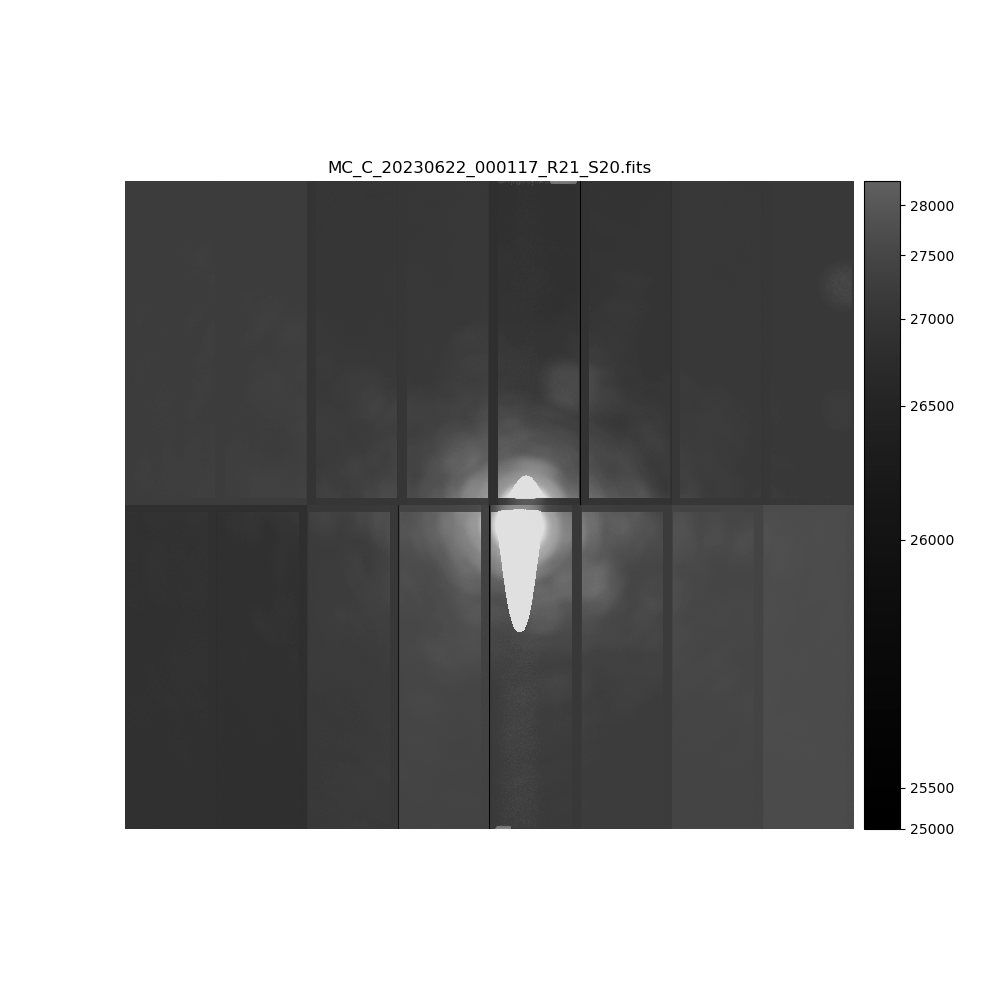

In [14]:
bias = butler.get(myccd)
display(bias,bias.getMetadata()["FILENAME"])
plt.show()


Display ISRed image

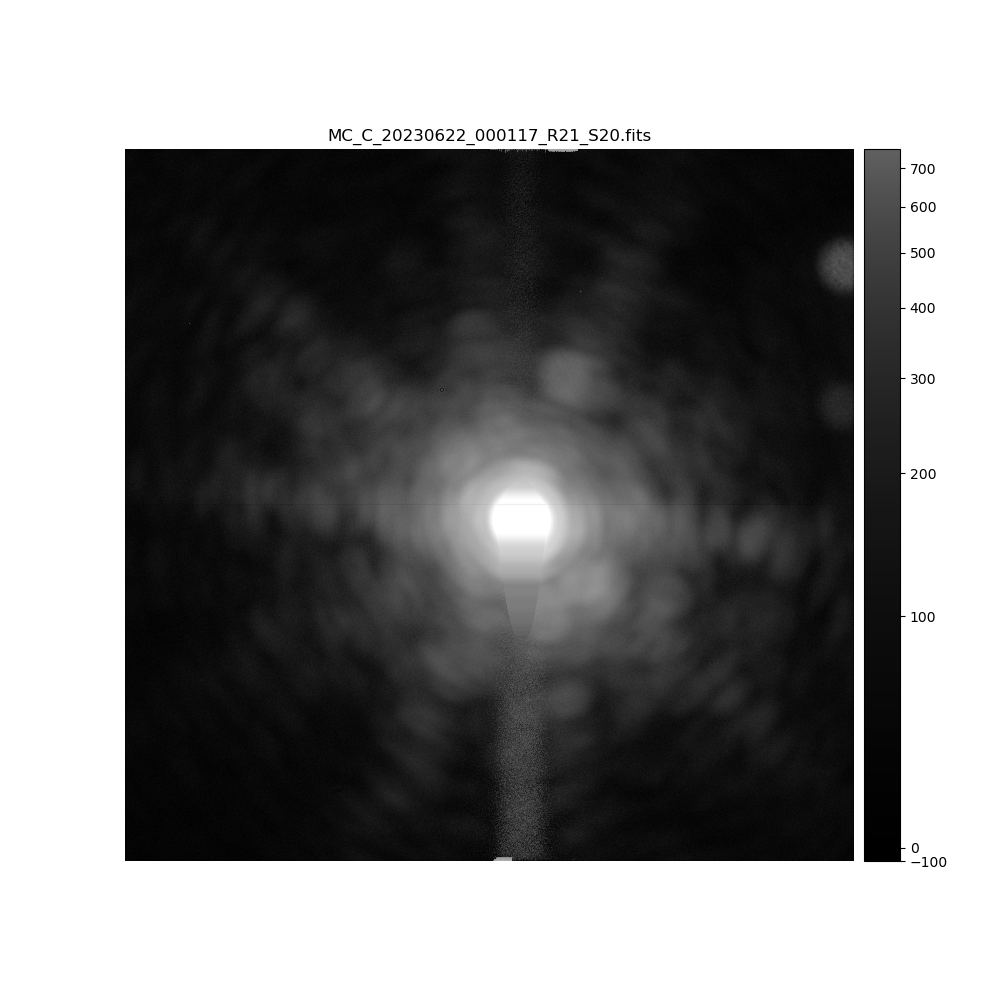

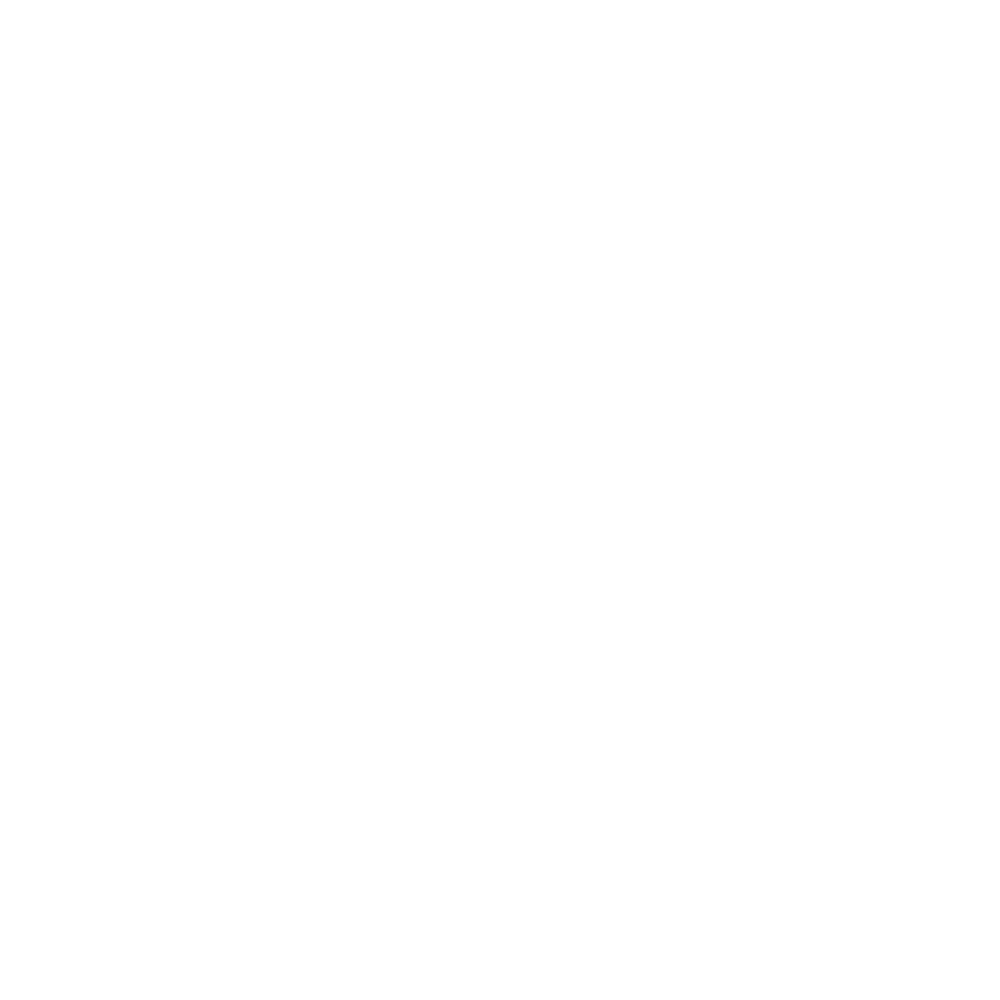

In [15]:
isr = IsrTask()
isr.config.doLinearize=False
isr.config.doDark=False
isr.config.doBias=False
isr.config.doFlat=False
isr.config.doDefect=False
isr.config.overscan.fitType: 'MEDIAN_PER_ROW'
#isr.config.overscan.fitType: 'CUBIC_SPLINE'

postISRCCD = isr.run(bias)
display(postISRCCD.exposure,bias.getMetadata()["FILENAME"])

plt.show()

In [16]:
imgarray = postISRCCD.exposure.getImage().getArray()

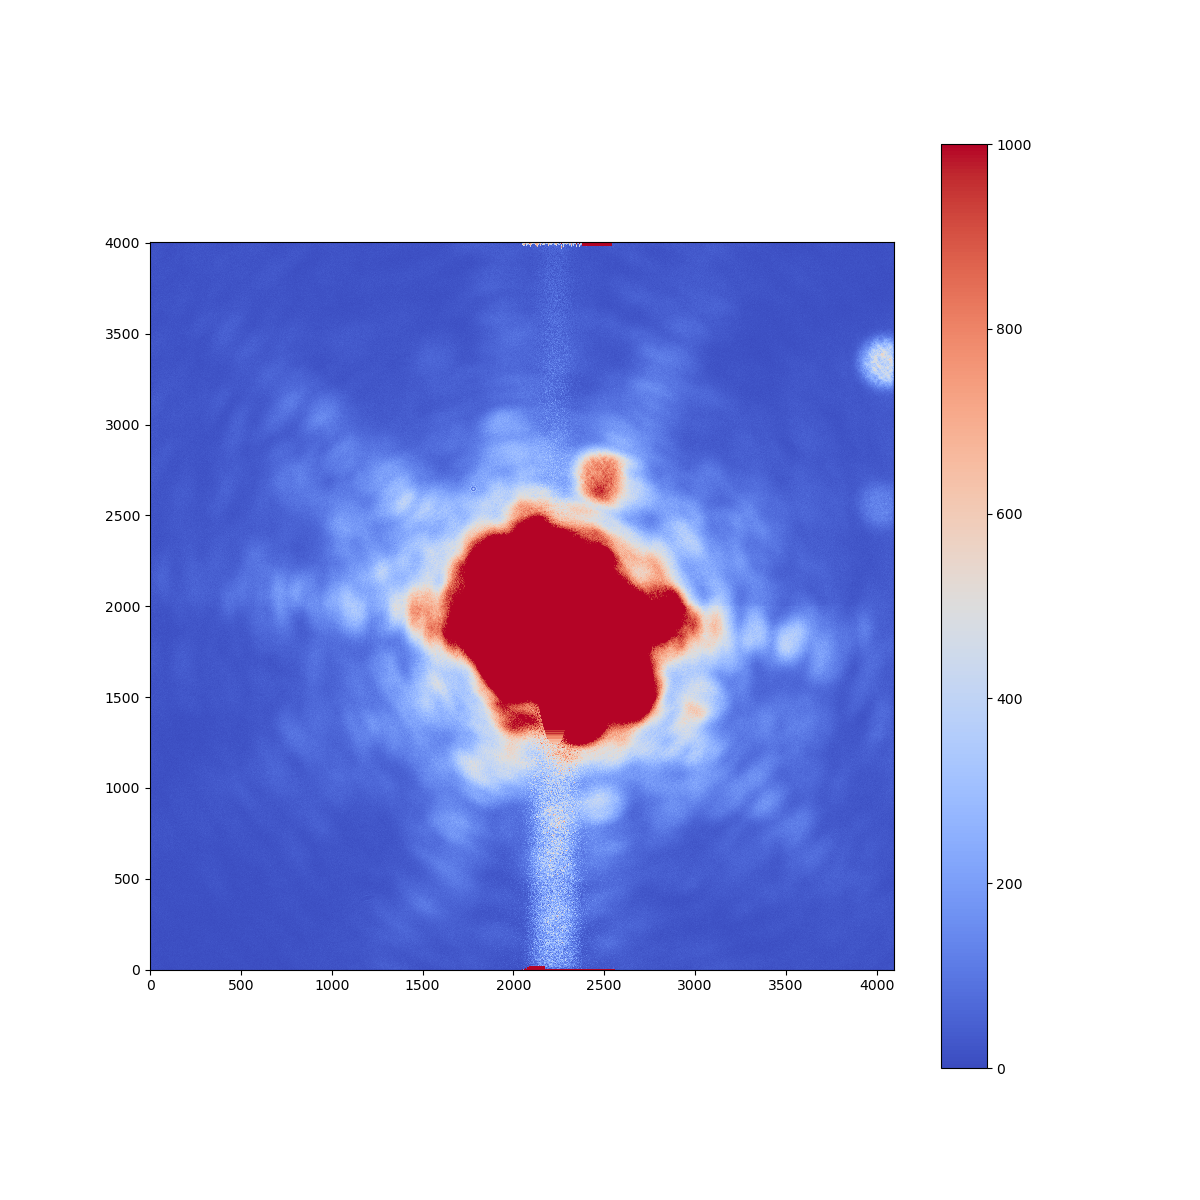

In [17]:
plotimg(imgarray, vmin=0, vmax=1000)

In [18]:
imgarray[2200:2800,3800:].shape

(600, 296)

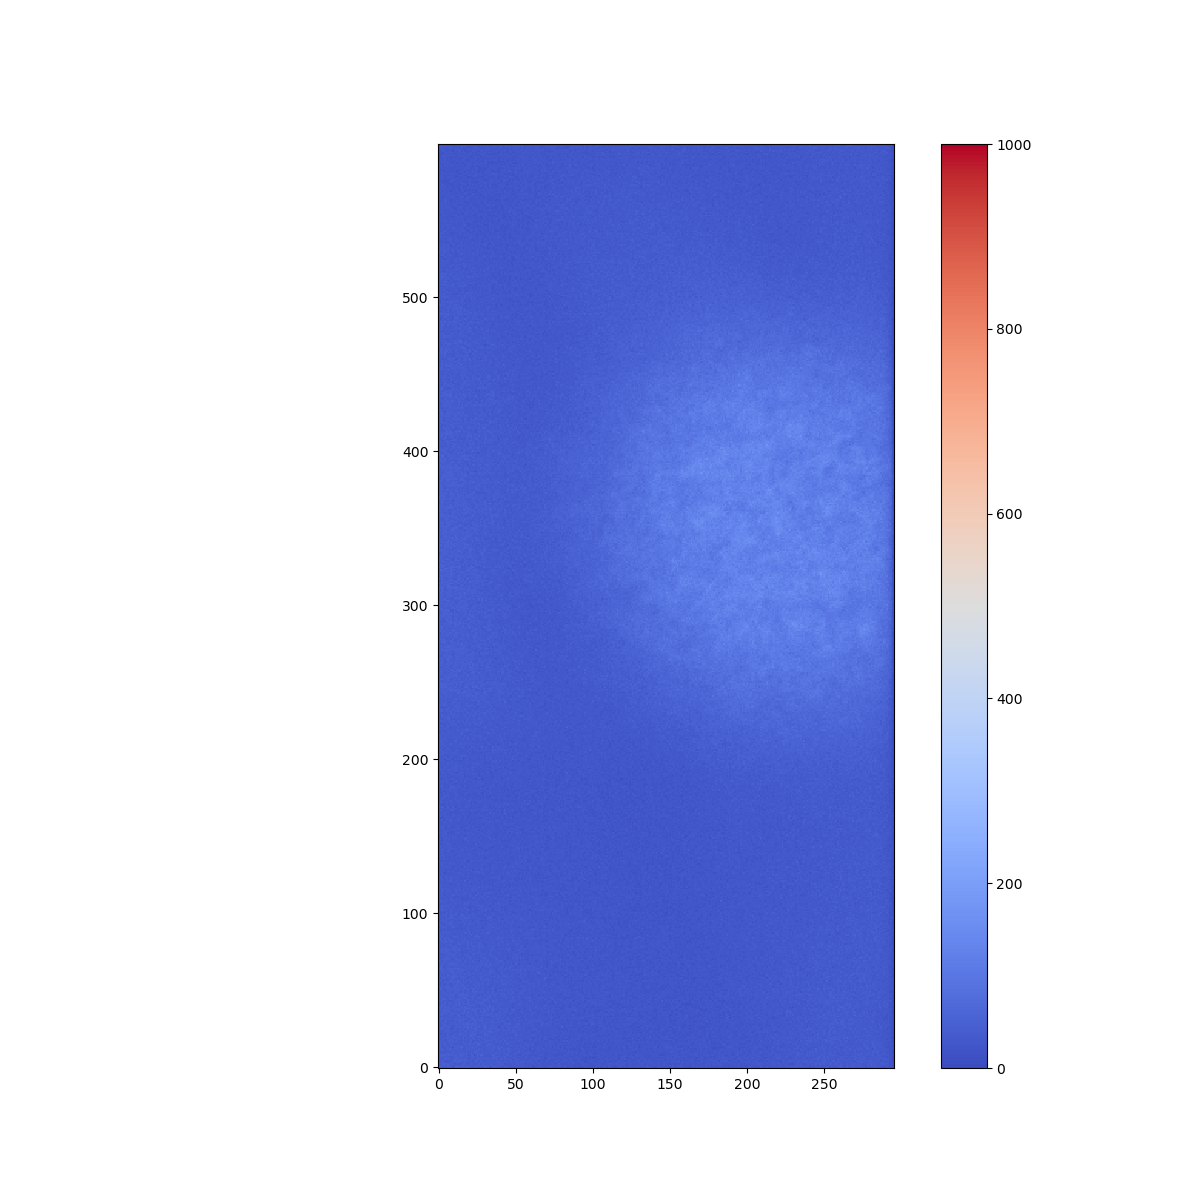

In [19]:
spot=imgarray[2200:2800,3800:]
plotimg(spot, vmin=0, vmax=1000)

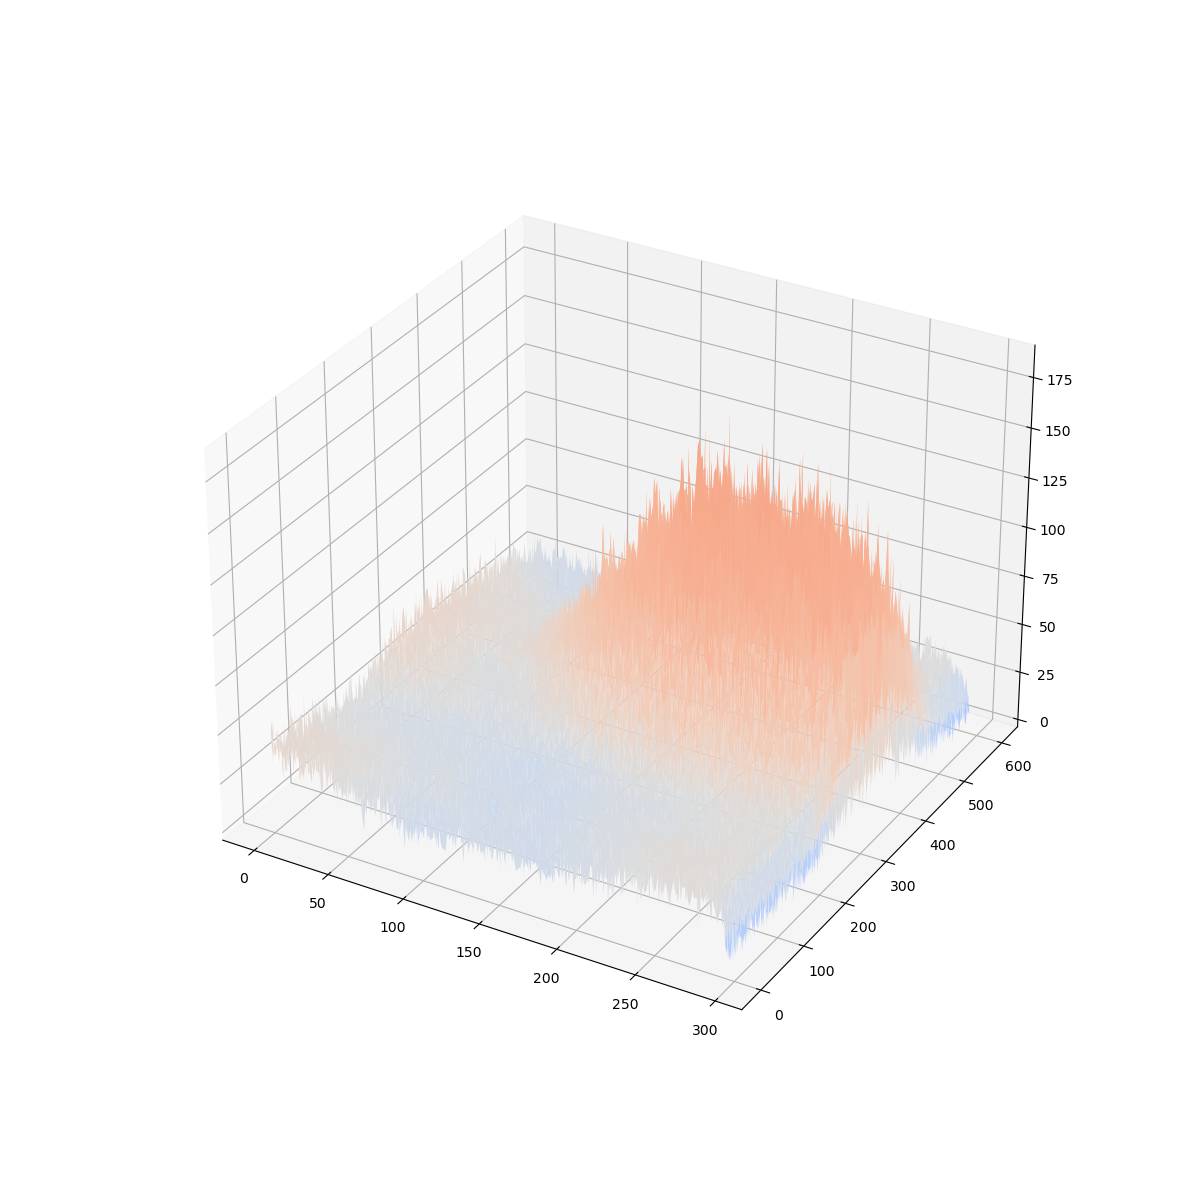

In [20]:
xbins=range(spot.shape[1])
ybins=range(spot.shape[0])
X, Y = np.meshgrid(xbins, ybins)
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 12))
surf = ax.plot_surface(X, Y, spot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True, norm=colors.LogNorm(vmin=1, vmax=1000))
#ax.set_zlim(1, 1000)

In [21]:
xbins=range(imgarray.shape[1])
ybins=range(imgarray.shape[0])
X, Y = np.meshgrid(xbins, ybins)


(1.0, 1000.0)

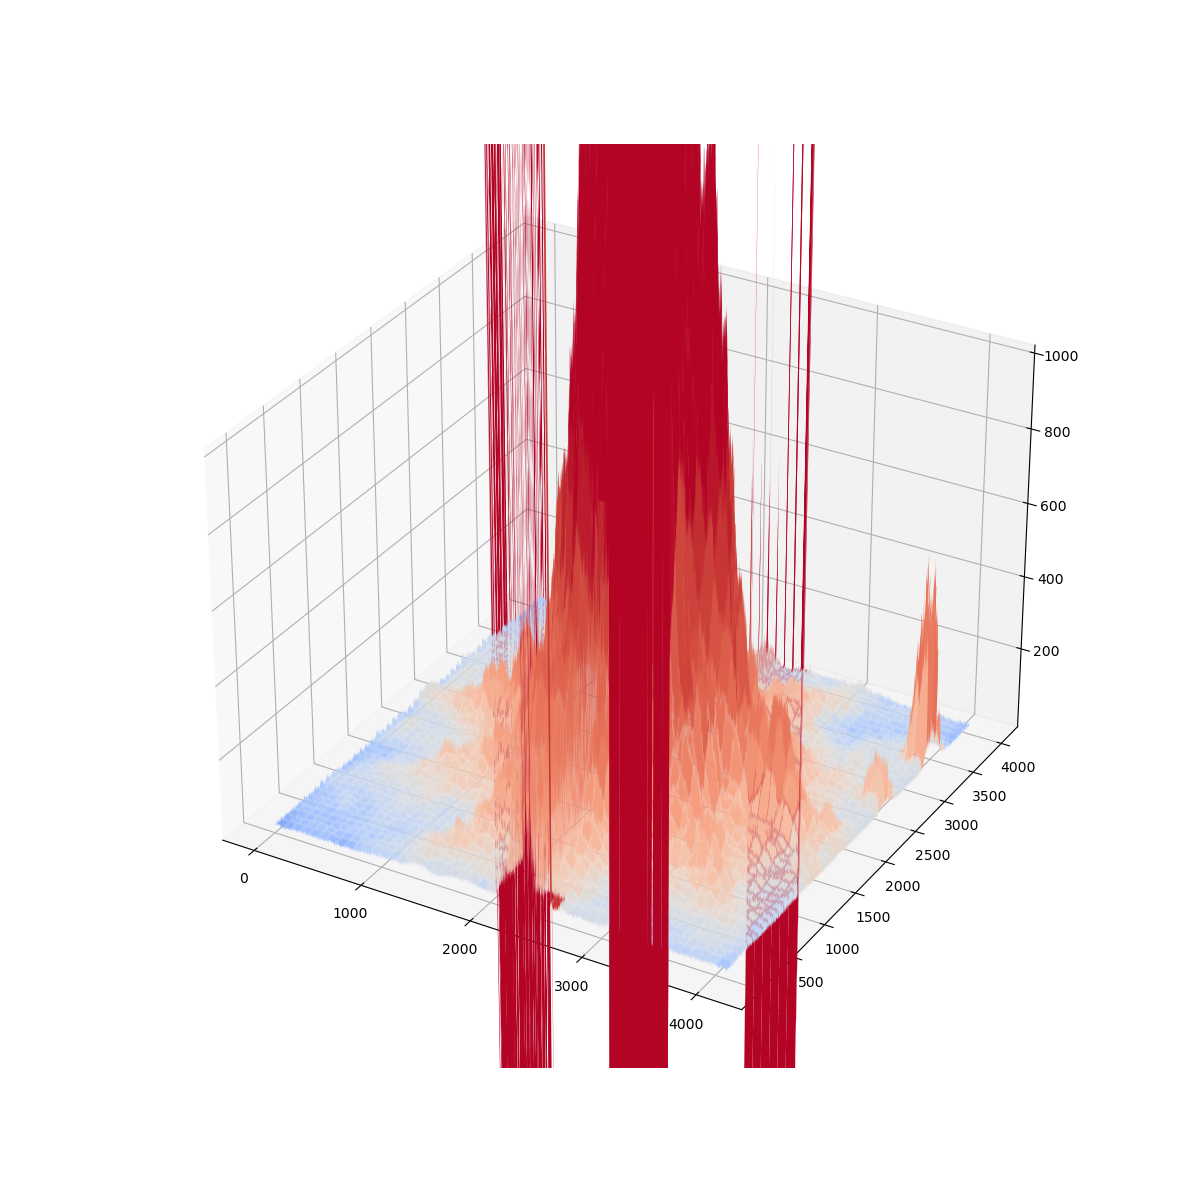

In [22]:
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 12))
surf = ax.plot_surface(X, Y, imgarray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True, norm=colors.LogNorm(vmin=1, vmax=1000))
ax.set_zlim(1, 1000)

In [23]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

print(imgarray.shape)
print(imgarray[4:][:].shape)

#roughimg=rebin(imgarray, (1001, 512))
roughimg=rebin(imgarray[4:][:], (500, 512))



(4004, 4096)
(4000, 4096)


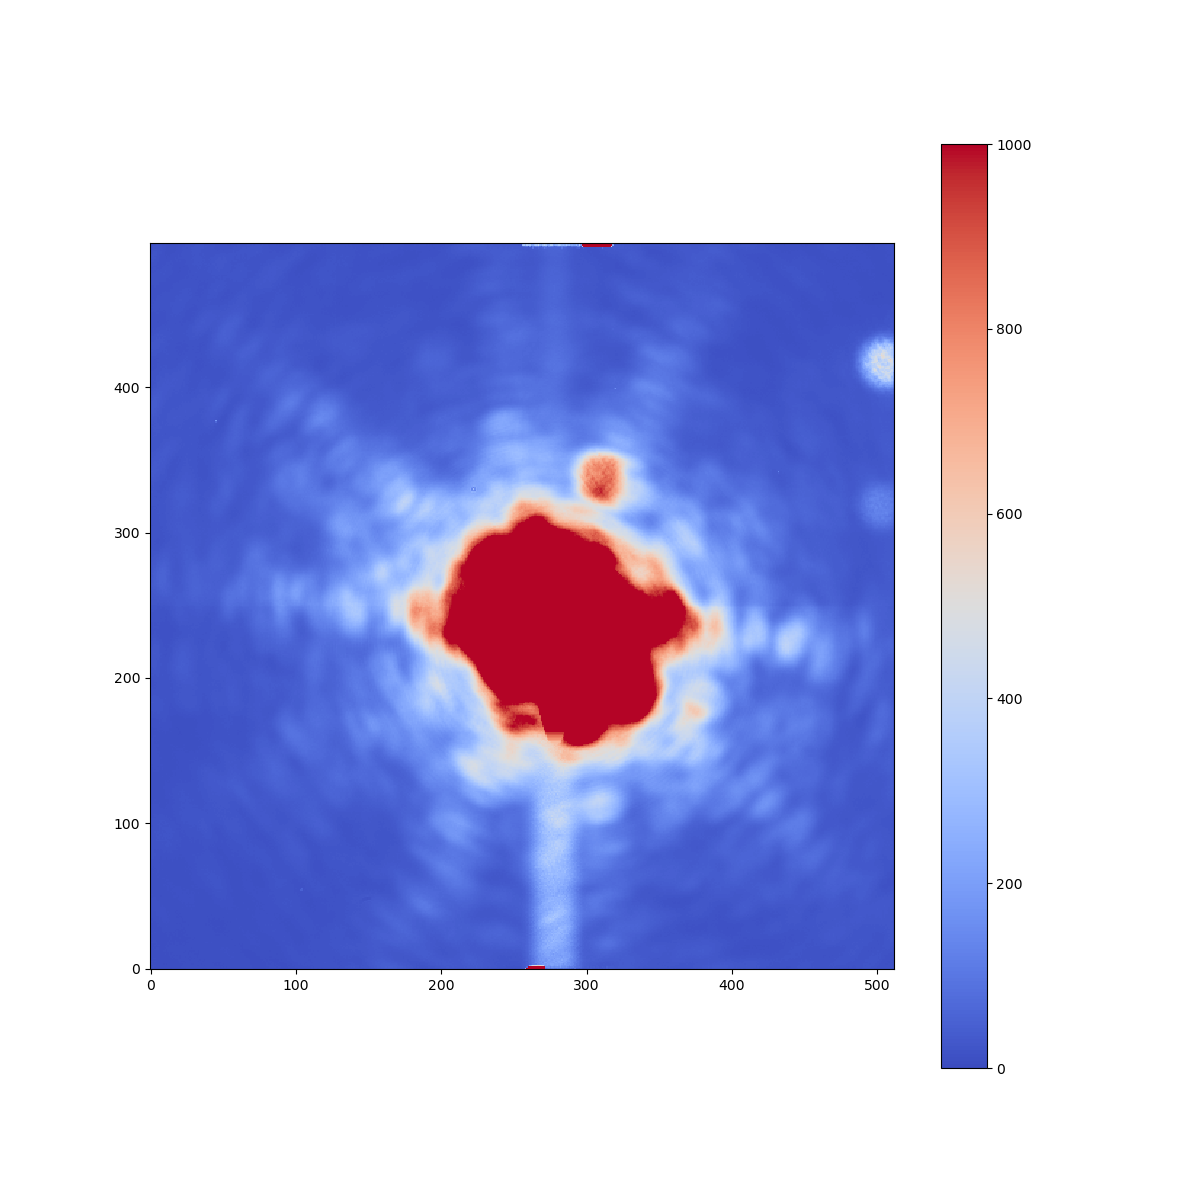

In [24]:
plotimg(roughimg, vmax=1000)

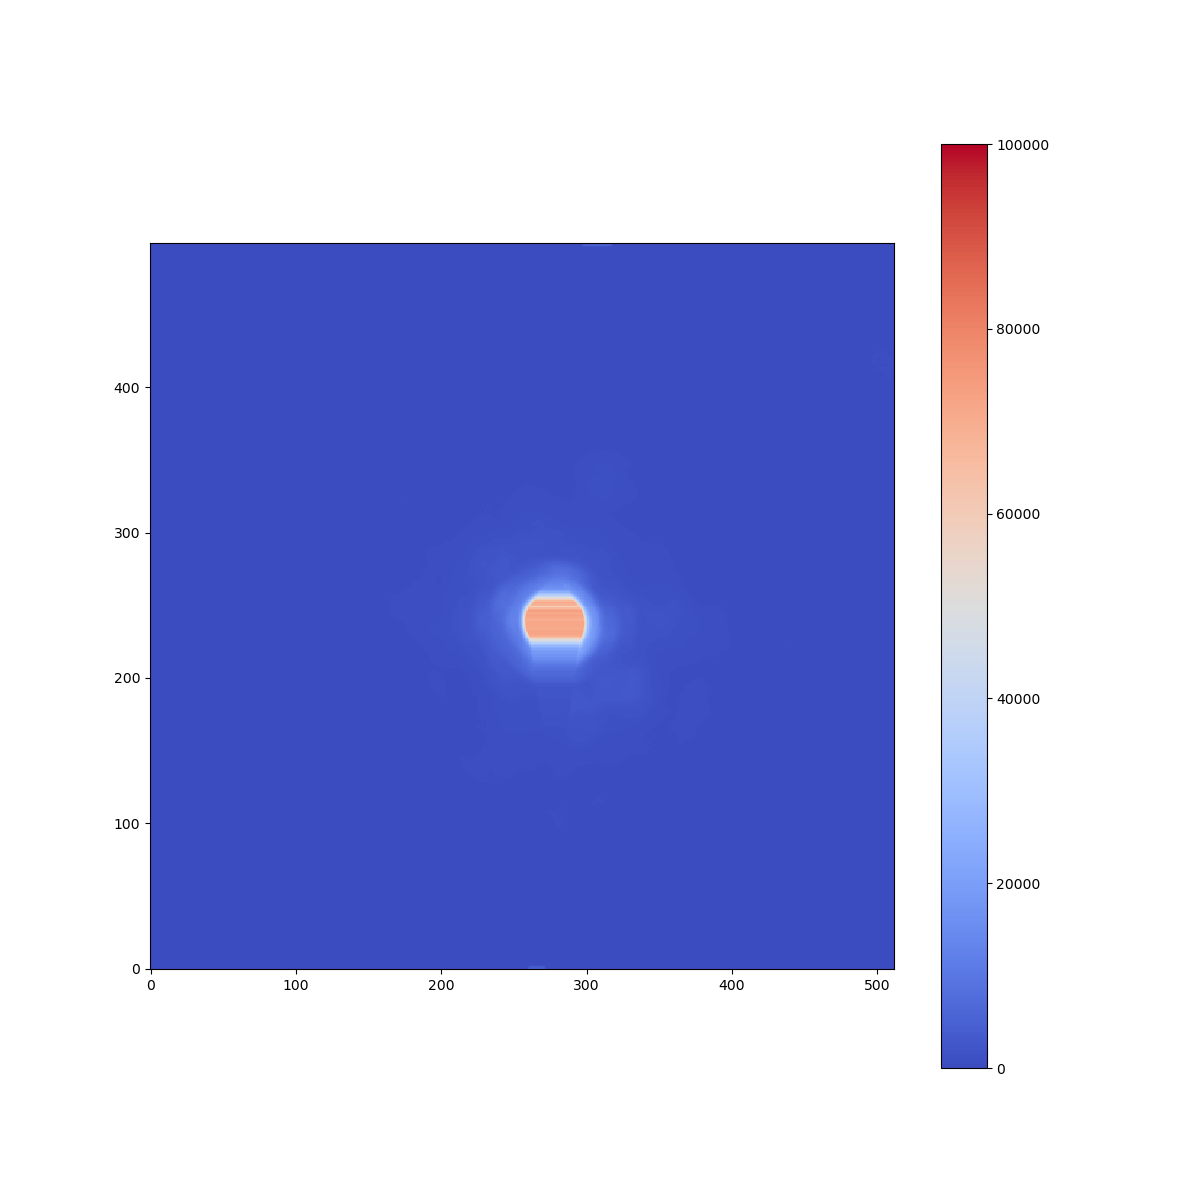

In [25]:
plotimg(roughimg)

In [ ]:
import numpy as np
import matplotlib.colors as colors
from matplotlib import cm
from astropy.convolution import convolve
from astropy.convolution.kernels import Gaussian2DKernel

fig, ax = plt.subplots(1, figsize=(12, 12))
xbins=range(imgarray.shape[1])
ybins=range(imgarray.shape[0])
X, Y = np.meshgrid(xbins, ybins)

smoothimg = convolve(imgarray, Gaussian2DKernel(x_stddev=2))

im_1 = ax.pcolormesh(X, Y, smoothimg, cmap=cm.coolwarm, shading='auto',
                     norm=colors.LogNorm(vmin=0.1, vmax=1000))
ax.set_aspect('equal')
fig.colorbar(im_1, ax=ax)
plt.show()

In [ ]:
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 12))
surf = ax.plot_surface(X, Y, smoothimg, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.set_zlim(-10, 100)

In [ ]:
X, Y